In [7]:
import os
import kagglehub
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Download the dataset
path = kagglehub.dataset_download("jagdishchakole1/mango-data")
print("Path to dataset files:", path)

# Define data directories
train_dir = os.path.join(path, "Mango_leaf_disease1/train")
val_dir = os.path.join(path, "Mango_leaf_disease1/val")
test_dir = os.path.join(path, "Mango_leaf_disease1/test")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Just rescaling for validation and test sets
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Path to dataset files: /kaggle/input/mango-data


In [8]:
input_shape = (224, 224)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape,
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape,
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Get the number of classes
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")
print("Class mapping:", train_generator.class_indices)

Found 2800 images belonging to 8 classes.
Found 800 images belonging to 8 classes.
Found 400 images belonging to 8 classes.
Number of classes: 8
Class mapping: {'Anthracnose': 0, 'Bacterial Canker': 1, 'Cutting Weevil': 2, 'Die Back': 3, 'Gall Midge': 4, 'Healthy': 5, 'Powdery Mildew': 6, 'Sooty Mould': 7}


In [9]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 50s 435ms/step - accuracy: 0.5028 - loss: 1.4139 - val_accuracy: 0.9463 - val_loss: 0.2708 - learning_rate: 1.0000e-04
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.9375 - loss: 0.2078 - learning_rate: 1.0000e-04
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 34s 361ms/step - accuracy: 0.8944 - loss: 0.3547 - val_accuracy: 0.9725 - val_loss: 0.1373 - learning_rate: 1.0000e-04
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step - accuracy: 0.8438 - loss: 0.3488 - learning_rate: 1.0000e-04
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 34s 361ms/step - accuracy: 0.9342 - loss: 0.2191 - val_accuracy: 0.9800 - val_loss: 0.1011 - learning_rate: 1.0000e-04
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step - accuracy: 0.9062 - loss: 0.2576 - learning_rate: 1.0000e-04
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 33s 353ms/step - accuracy: 0.9559 - loss: 0.1550 - val_accuracy: 0.9787 - val_loss: 0.0824 - learning_rate: 1.0000e-04
Epoch 8/20
87/87 ━━━━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 0.9987 - loss: 0.0252
Test accuracy: 0.9950


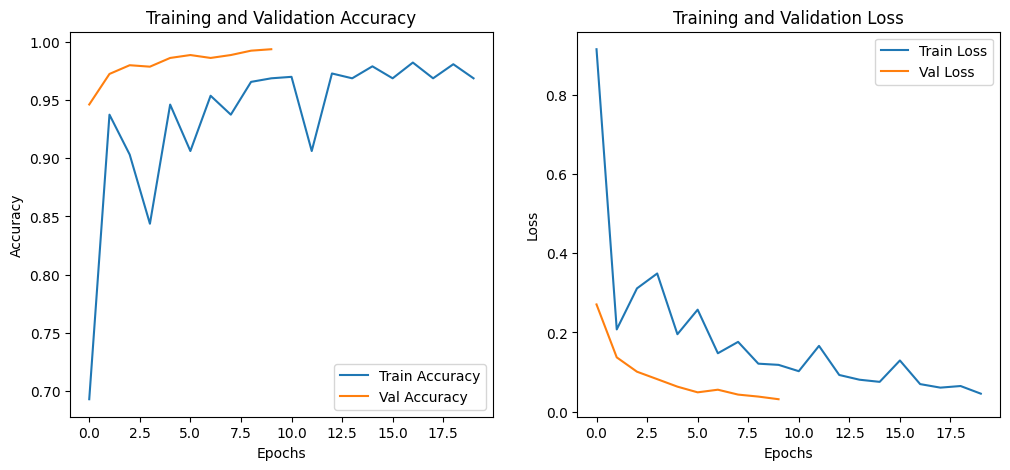

Test accuracy after fine-tuning: 0.9950


In [11]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

# Save the model
model.save('mango_disease_mobilenet_model.h5')

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

plot_history(history)

print(f"Test accuracy after fine-tuning: {test_acc:.4f}")